In [221]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [222]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [223]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.5#0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 3000
Test set size: 3000


In [224]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])

In [225]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

In [226]:
dim1_data_scaled = t_x_data

def prepare_data(dim1_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation - mock of the real function (just for x here, no y and theta)
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)

    x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data[:,0] = t_x[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

# from dataset_prep import prepare_data
train_validate_ratio = 0.5
train_ds,valid_ds = \
prepare_data(dim1_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([2998, 2])
x_train dimensions: torch.Size([1499, 2])
x_valid dimensions: torch.Size([1499, 2])
y_data dimensions: torch.Size([2998, 1])
y_train dimensions: torch.Size([1499, 1])
y_valid dimensions: torch.Size([1499, 1])


In [227]:
import torch.nn as nn
import torch.nn.functional as F
#our class must extend nn.Module
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(input_size,3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,output_size)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.relu(x) # F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x    
    
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

In [231]:
from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 20
epochs = 10
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = MyClassifier() #Network()
loss_func = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


0 0.009536722831532429
1 0.0062041215140688135
2 0.005718222859109304
3 0.00554089462775998
4 0.005734473079922308
5 0.006084564473021625
6 0.005581742651006325
7 0.005694083978650001
8 0.005445366744216864
9 0.00539552027213911


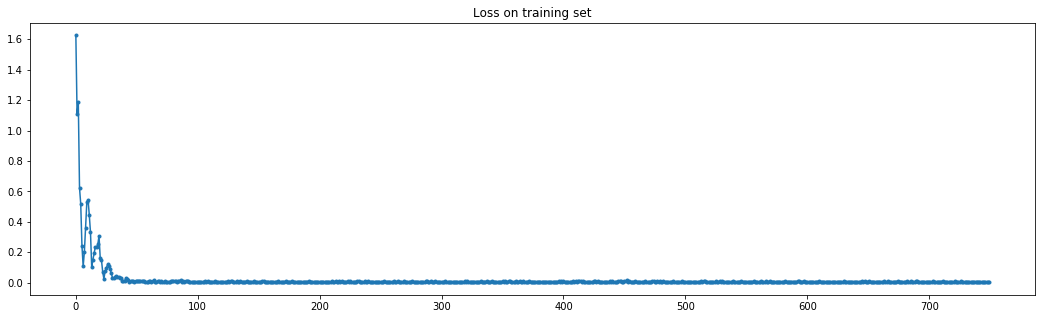

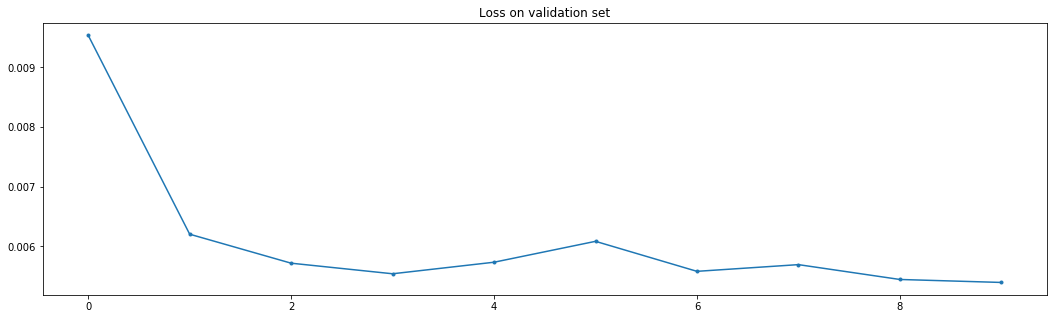

In [232]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

Text(0.5, 1.0, 'Pose in x direction')

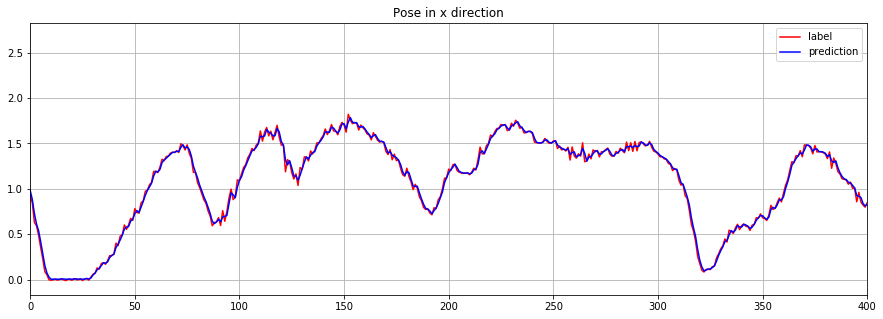

In [233]:
valid_loader = DataLoader(dataset=valid_ds,
                                     batch_size=len(valid_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(valid_loader))
prediction = model(batch_x).data
# print(batch_x.shape, batch_y.shape)
# print(batch_x)
# print(prediction)
# print(batch_y)

plt.figure(figsize=(15,5))
plt.plot(batch_y,'r',label="label")
plt.plot(prediction[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction")